# Backpropagation en PyTorch

En este ejemplo se define una función compuesta  
$$ 
z = 2(x+3)^2 + 1
$$
y se calcula la derivada $\frac{dz}{dx} $ utilizando `autograd` de PyTorch.  
El tensor $x$ se marca con `requires_grad=True` para que PyTorch construya el grafo computacional y pueda propagar el gradiente al ejecutar `z.backward()`.


In [ ]:
import torch

# Definimos x como un tensor que requiere gradiente
x = torch.tensor(1.0, requires_grad=True)

# Definimos y y z
y = x + 3
z = 2 * y**2 + 1

# Calculamos la derivada dz/dx
z.backward()

# Imprimimos el resultado
print("dz/dx en x=1:", x.grad.item())


dz/dx en x=1: 16.0


## Librerías necesarias

In [ ]:
# Importación de librerías
import math                      # Funciones matemáticas básicas
import numpy as np               # Operaciones vectoriales y matriciales
import matplotlib.pyplot as plt  # Gráficas

# Mostrar las gráficas dentro del notebook
%matplotlib inline


## Visualización del grafo computacional

Esta función recorre los nodos que intervienen en el cálculo de una expresión y construye una gráfica dirigida que muestra las operaciones, los valores y los gradientes asociados. El grafo se genera con Graphviz y permite visualizar cómo fluye la información durante backpropagation.


In [ ]:
from graphviz import Digraph

def rastrear(raiz):
    # Recorre el grafo desde 'raiz' hacia atrás y registra nodos y aristas
    nodos, aristas = [], []

    def construir(nodo):
        if nodo not in nodos:              # Evita procesar nodos repetidos
            nodos.append(nodo)
            for padre in nodo.x_entradas:  # Cada padre es una entrada del nodo actual
                aristas.append((padre, nodo))
                construir(padre)           # Recursivamente seguimos hacia atrás

    construir(raiz)
    return tuple(nodos), tuple(aristas)

def digrafica(raiz):
    # Configura un grafo dirigido en formato SVG orientado de izquierda a derecha
    grafo = Digraph(format='svg', graph_attr={'rankdir': 'LR'})

    nodos, aristas = rastrear(raiz)

    # Dibujar nodos con valor y gradiente
    for nodo in nodos:
        id_unico = str(id(nodo))
        grafo.node(
            name=id_unico,
            label="{ %s | valor %.4f | gradiente %.4f }" % (nodo.etiqueta, nodo.valor, nodo.grad),
            shape='record'
        )

        # Si el nodo tiene una operación, se agrega como nodo adicional
        if nodo.operacion:
            grafo.node(name=id_unico + nodo.operacion, label=nodo.operacion)
            grafo.edge(id_unico + nodo.operacion, id_unico)

    # Dibujar conexiones padre → hijo
    for padre, hijo in aristas:
        grafo.edge(str(id(padre)), str(id(hijo)) + hijo.operacion)

    return grafo


## Implementación manual de nodos diferenciables

Esta clase define un nodo del grafo computacional con un valor numérico, su gradiente y la operación que lo generó. Cada operación elemental (suma y multiplicación) construye un nuevo nodo e incluye una función `retropropagar` que aplica la regla de la cadena para actualizar los gradientes de sus entradas. Esta estructura permite realizar backpropagation de manera explícita sin depender de librerías externas.


In [ ]:
class Valor:

    def __init__(self, valor, x_entradas=(), operacion='', etiqueta=''):
        self.valor = valor                 # Valor numérico del nodo
        self.grad = 0.0                    # Gradiente acumulado (dz/dvariable)
        self.retropropagar = lambda: None  # Función para realizar backpropagation
        self.x_entradas = x_entradas       # Nodos de entrada que generaron este valor
        self.operacion = operacion         # Operación que produjo el nodo
        self.etiqueta = etiqueta           # Nombre opcional

    def __repr__(self):
        return f"Valor(dato={self.valor})"

    # Implementación de la operación suma: x1 + x2
    def __add__(self, x2):
        x1 = self
        res_suma = x1.valor + x2.valor
        y = Valor(res_suma, (x1, x2), "+", "")

        def retro():
            # y = x1 + x2
            # dy/dx1 = 1, dy/dx2 = 1
            dz_dy = y.grad
            x1.grad = dz_dy * 1
            x2.grad = dz_dy * 1

        y.retropropagar = retro
        return y

    # Implementación de la operación multiplicación: x1 * x2
    def __mul__(self, x2):
        x1 = self
        res_mult = x1.valor * x2.valor
        y = Valor(res_mult, (x1, x2), "*", "")

        def retro():
            # y = x1 * x2
            dz_dy = y.grad
            x1.grad = dz_dy * x2.valor   # dy/dx1 = x2
            x2.grad = dz_dy * x1.valor   # dy/dx2 = x1

        y.retropropagar = retro
        return y


## Construcción del grafo y propagación del gradiente

En este ejemplo se crean los nodos `v`, `b`, `u`, `a` y `w`, y se construye el grafo computacional mediante las operaciones definidas en la clase `Valor`.  
Se asigna un gradiente inicial de 1 a `w` para simular \(\frac{dz}{dw}=1\), y luego se llama a `retropropagar()` para actualizar los gradientes de sus nodos dependientes.  
Finalmente, se utiliza `digrafica(w)` para visualizar el grafo resultante junto con sus valores y gradientes.


Valor(dato=20.0)


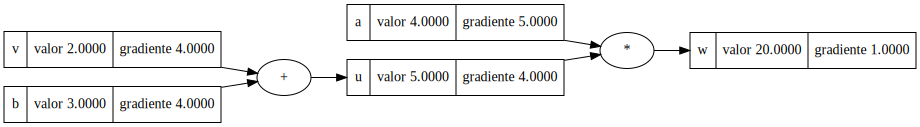

In [ ]:
# Creamos los nodos base con sus valores y etiquetas
v = Valor(2.0, etiqueta='v')
b = Valor(3.0, etiqueta='b')

# Operación: u = v + b
u = v + b
u.etiqueta = 'u'

# Creamos otro nodo
a = Valor(4.0, etiqueta='a')

# Operación: w = a * u
w = a * u
w.etiqueta = 'w'

# Mostramos el nodo final
print(w)

# Asignamos gradiente inicial a w (equivalente a dz/dw = 1)
w.grad = 1

# Propagamos gradientes hacia los nodos que componen w
w.retropropagar()  # afecta a 'a' y 'u'
u.retropropagar()  # continúa hacia 'v' y 'b'

# Visualizamos el grafo computacional con valores y gradientes
digrafica(w)